In [3]:
!pip install kaggle kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 700.6 kB/s eta 0:00:00a 0:00:01


In [13]:
!pip install tensorflow opencv-python numpy pandas matplotlib seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 234.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 1.6 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 1.8 MB/s eta 0:00:0000:0100:01


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

/home/udara/ml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████████████████████████████████████████████████████████████████████████| 2.29G/2.29G [14:49<00:00, 2.77MB/s]

Extracting files...


Path to dataset files: /home/udara/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
                                   Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet121, ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import os
import warnings
warnings.filterwarnings('ignore')

In [25]:
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Preprocessing

In [26]:
CONFIG = {
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 32,
    'EPOCHS': 50,
    'LEARNING_RATE': 0.0001,
    'TRAIN_PATH': 'dataset/train',
    'VAL_PATH': 'dataset/val', 
    'TEST_PATH': 'dataset/test',
    'MODEL_SAVE_PATH': 'pneumonia_model_best.h5'
}

In [27]:
def medical_image_enhancement(image_path, save_path=None):
    """
    Apply medical-specific image enhancement techniques
    """
    # Read image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        return None
        
    # Step 1: CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)
    
    # Step 2: Bilateral filtering to preserve edges while reducing noise
    img_bilateral = cv2.bilateralFilter(img_clahe, 9, 75, 75)
    
    # Step 3: Gaussian smoothing with 5x5 kernel for noise reduction  
    img_gaussian = cv2.GaussianBlur(img_bilateral, (5,5), 0)
    
    # Convert to 3-channel RGB for compatibility with pretrained models
    img_rgb = cv2.merge([img_gaussian] * 3)
    
    # Resize to target size
    img_resized = cv2.resize(img_rgb, CONFIG['IMG_SIZE'])
    
    if save_path:
        cv2.imwrite(save_path, img_resized)
    
    return img_resized

In [28]:
def preprocess_dataset_folder(input_folder, output_folder):
    """
    Apply preprocessing to entire dataset folder
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for class_folder in os.listdir(input_folder):
        class_input_path = os.path.join(input_folder, class_folder)
        class_output_path = os.path.join(output_folder, class_folder)
        
        if not os.path.exists(class_output_path):
            os.makedirs(class_output_path)
        
        if os.path.isdir(class_input_path):
            print(f"Processing {class_folder} images...")
            for img_file in os.listdir(class_input_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    input_path = os.path.join(class_input_path, img_file)
                    output_path = os.path.join(class_output_path, img_file)
                    
                    enhanced_img = medical_image_enhancement(input_path)
                    if enhanced_img is not None:
                        cv2.imwrite(output_path, enhanced_img)
            print(f"✓ Completed {class_folder}")

### Data Generation

In [29]:
def create_data_generators():
    """
    Create data generators with medical-appropriate augmentation
    """
    # Training data generator with medical-safe augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,          # ±15° (lungs can appear at slight angles)
        zoom_range=0.15,            # Slight zoom
        width_shift_range=0.1,      # Small translations
        height_shift_range=0.1,
        brightness_range=[0.8, 1.2], # ±20% brightness
        fill_mode='nearest',
        validation_split=0.2        # 80-20 train-val split
        # NO horizontal_flip for chest X-rays!
    )
    
    # Validation and test generators (no augmentation, only rescaling)
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create data generators
    train_generator = train_datagen.flow_from_directory(
        CONFIG['TRAIN_PATH'],
        target_size=CONFIG['IMG_SIZE'],
        batch_size=CONFIG['BATCH_SIZE'],
        class_mode='binary',
        subset='training',
        seed=42
    )
    
    validation_generator = train_datagen.flow_from_directory(
        CONFIG['TRAIN_PATH'],
        target_size=CONFIG['IMG_SIZE'],
        batch_size=CONFIG['BATCH_SIZE'],
        class_mode='binary',
        subset='validation',
        seed=42
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        CONFIG['TEST_PATH'],
        target_size=CONFIG['IMG_SIZE'],
        batch_size=CONFIG['BATCH_SIZE'],
        class_mode='binary',
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

### MODEL ARCHITECTURES

In [30]:
def create_custom_cnn():
    """
    Create custom CNN architecture for pneumonia detection
    """
    model = Sequential([
        # First Conv Block
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Second Conv Block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(), 
        MaxPooling2D(2, 2),
        
        # Third Conv Block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Fourth Conv Block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        
        # Classification Head
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    return model

In [31]:
def create_transfer_learning_model(base_model_name='DenseNet121'):
    """
    Create transfer learning model (recommended approach)
    """
    # Load pre-trained base model
    if base_model_name == 'DenseNet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, 
                                input_shape=(224, 224, 3))
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False,
                             input_shape=(224, 224, 3))
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False,
                          input_shape=(224, 224, 3))
    
    # Freeze base model initially
    base_model.trainable = False
    
    # Add custom classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    return model, base_model

### Class Imbalance Handling

In [32]:
def calculate_class_weights(train_generator):
    """
    Calculate class weights to handle imbalance
    """
    # Get class labels
    labels = train_generator.classes
    class_labels = np.unique(labels)
    
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=class_labels, y=labels)
    class_weight_dict = dict(zip(class_labels, class_weights))
    
    print("Class distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for i, (cls, count) in enumerate(zip(unique, counts)):
        print(f"Class {cls}: {count} samples")
    
    print(f"Class weights: {class_weight_dict}")
    return class_weight_dict

### TRAINING PIPELINE

In [33]:
def train_model(model, train_gen, val_gen, class_weights, model_name="pneumonia_model"):
    """
    Complete training pipeline with callbacks and monitoring
    """
    # Compile model with appropriate metrics for medical classification
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    
    # Setup callbacks
    callbacks = [
        # Save best model
        ModelCheckpoint(
            filepath=f'{model_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        
        # Early stopping
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Learning rate reduction
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    # Calculate steps per epoch
    steps_per_epoch = len(train_gen)
    validation_steps = len(val_gen)
    
    print(f"Training steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")
    
    # Train the model
    history = model.fit(
        train_gen,
        epochs=CONFIG['EPOCHS'],
        validation_data=val_gen,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    
    return history

### EVALUATION AND METRICS

In [34]:
def evaluate_model(model, test_generator):
    """
    Comprehensive model evaluation with medical-specific metrics
    """
    # Get predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    true_classes = test_generator.classes
    
    # Classification report
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(true_classes, predicted_classes, 
                              target_names=['Normal', 'Pneumonia']))
    
    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve and AUC
    auc = roc_auc_score(true_classes, predictions)
    fpr, tpr, thresholds = roc_curve(true_classes, predictions)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Calculate medical-specific metrics
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn)  # Recall for pneumonia detection
    specificity = tn / (tn + fp)  # True negative rate
    precision = tp / (tp + fp)    # Positive predictive value
    npv = tn / (tn + fn)         # Negative predictive value
    
    print("\n" + "="*50)
    print("MEDICAL PERFORMANCE METRICS")
    print("="*50)
    print(f"Sensitivity (Recall): {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"Precision (PPV): {precision:.3f}")
    print(f"Negative Predictive Value: {npv:.3f}")
    print(f"AUC-ROC: {auc:.3f}")
    
    return {
        'predictions': predictions,
        'predicted_classes': predicted_classes,
        'true_classes': true_classes,
        'auc': auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision
    }

### MAIN EXECUTION PIPELINE

In [35]:
def main():
    """
    Main execution pipeline
    """
    print("🔥 STARTING PNEUMONIA DETECTION PIPELINE")
    print("="*60)
    
    # Preprocess dataset 
    print("Dataset Preprocessing...")
    preprocess_dataset_folder('raw_dataset/train', 'dataset/train')
    preprocess_dataset_folder('raw_dataset/val', 'dataset/val')
    preprocess_dataset_folder('raw_dataset/test', 'dataset/test')
    
    # Create data generators
    print("Creating Data Generators...")
    train_gen, val_gen, test_gen = create_data_generators()
    
    print(f"Training samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")
    print(f"Test samples: {test_gen.samples}")
    
    # Handle class imbalance
    print("Calculating Class Weights...")
    class_weights = calculate_class_weights(train_gen)
    
    # Create model
    print("Creating Model...")
    
    
    model = create_custom_cnn()
    model_name = "pneumonia_custom_cnn"
    
    print(f"Model: {model_name}")
    print(f"Total parameters: {model.count_params():,}")
    
    # Step 5: Train model
    print("🏃 Step 5: Training Model...")
    history = train_model(model, train_gen, val_gen, class_weights, model_name)
    
    # Step 6: Fine-tuning (for transfer learning)
    if 'base_model' in locals():
        print("🔧 Step 6: Fine-tuning...")
        # Unfreeze top layers of base model
        base_model.trainable = True
        
        # Fine-tune from this layer onwards
        fine_tune_at = len(base_model.layers) - 20
        
        # Freeze all layers before fine_tune_at
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        
        # Recompile with lower learning rate
        model.compile(
            optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']/10),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )
        
        # Fine-tune training
        history_fine = train_model(model, train_gen, val_gen, class_weights, 
                                 f"{model_name}_finetuned")
    
    # Step 7: Evaluate model
    print(" Model Evaluation...")
    results = evaluate_model(model, test_gen)
    
    # Step 8: Save final model
    print(" Saving Model...")
    model.save(f'{model_name}_final.h5')
    
    print("COMPLETED SUCCESSFULLY!")
    
    return model, history, results

### INFERENCE FUNCTION

In [36]:
def predict_pneumonia(model_path, image_path):
    """
    Make prediction on a single image
    """
    # Load trained model
    model = keras.models.load_model(model_path)
    
    # Preprocess image
    enhanced_img = medical_image_enhancement(image_path)
    if enhanced_img is None:
        return None, None
    
    # Normalize and expand dimensions
    img_array = enhanced_img.astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    prediction = model.predict(img_array)[0][0]
    
    # Interpret result
    if prediction > 0.5:
        diagnosis = "PNEUMONIA DETECTED"
        confidence = prediction * 100
    else:
        diagnosis = "NORMAL"
        confidence = (1 - prediction) * 100
    
    print(f"Diagnosis: {diagnosis}")
    print(f"Confidence: {confidence:.1f}%")
    
    return diagnosis, confidence

🔥 STARTING PNEUMONIA DETECTION PIPELINE
📁 Step 1: Dataset Preprocessing...
Creating Data Generators...
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training samples: 4173
Validation samples: 1043
Test samples: 624
Calculating Class Weights...
Class distribution:
Class 0: 1073 samples
Class 1: 3100 samples
Class weights: {np.int32(0): np.float64(1.9445479962721341), np.int32(1): np.float64(0.6730645161290323)}
Creating Model...
Model: pneumonia_custom_cnn
Total parameters: 524,481
🏃 Step 5: Training Model...
Training steps per epoch: 131
Validation steps: 33
Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6856 - loss: 0.6024 - precision: 0.9214 - recall: 0.6305
Epoch 1: val_accuracy improved from None to 0.74305, saving model to pneumonia_custom_cnn_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 43s 285ms/step - accuracy: 0.7515 - loss: 0.4967 - precision: 0.9562 - recall: 0.6974 - val_accuracy: 0.7430 - val_loss: 0.5873 - val_precision: 0.7430 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.8051 - loss: 0.4048 - precision: 0.9700 - recall: 0.7620
Epoch 2: val_accuracy did not improve from 0.74305
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.8150 - loss: 0.3944 - precision: 0.9663 - recall: 0.7781 - val_accuracy: 0.7430 - val_loss: 0.6324 - val_precision: 0.7430 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.8402 - loss: 0.3715 - precision: 0.9673 - recall: 0.8129
Epoch 3: val_accuracy did not improve from 0.74305
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 254ms/step - accuracy: 0.8385 - loss: 0.3708 - precision: 0.9626 - recall: 0.8142 - val_accuracy: 0.7430 - val_loss: 0.6784 - val_precision: 0.7430 - val_r

131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 264ms/step - accuracy: 0.8732 - loss: 0.2985 - precision: 0.9669 - recall: 0.8587 - val_accuracy: 0.9003 - val_loss: 0.2695 - val_precision: 0.9813 - val_recall: 0.8826 - learning_rate: 1.0000e-04
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.8848 - loss: 0.2787 - precision: 0.9749 - recall: 0.8684
Epoch 7: val_accuracy improved from 0.90029 to 0.92617, saving model to pneumonia_custom_cnn_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 275ms/step - accuracy: 0.8797 - loss: 0.2869 - precision: 0.9693 - recall: 0.8655 - val_accuracy: 0.9262 - val_loss: 0.1841 - val_precision: 0.9373 - val_recall: 0.9652 - learning_rate: 1.0000e-04
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8859 - loss: 0.2581 - precision: 0.9692 - recall: 0.8723
Epoch 8: val_accuracy improved from 0.92617 to 0.92713, saving model to pneumonia_custom_cnn_best.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 269ms/step - accuracy: 0.8831 - loss: 0.2731 - precision: 0.9688 - recall: 0.8706 - val_accuracy: 0.9271 - val_loss: 0.1954 - val_precision: 0.9807 - val_recall: 0.9200 - learning_rate: 1.0000e-04
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8891 - loss: 0.2663 - precision: 0.9684 - recall: 0.8790
Epoch 9: val_accuracy did not improve from 0.92713
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 266ms/step - accuracy: 0.8816 - loss: 0.2779 - precision: 0.9660 - recall: 0.8713 - val_accuracy: 0.4401 - val_loss: 1.8945 - val_precision: 1.0000 - val_recall: 0.2465 - learning_rate: 1.0000e-04
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8846 - loss: 0.2682 - precision: 0.9717 - recall: 0.8701
Epoch 10: val_accuracy did not improve from 0.92713
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 262ms/step - accuracy: 0.8994 - loss: 0.2497 - precision: 0.9738 - recall: 0.8884 - val_accuracy: 0.7747 - val_loss: 0.6201 - val_precision: 0.7684 - val

131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - accuracy: 0.9183 - loss: 0.2025 - precision: 0.9765 - recall: 0.9119 - val_accuracy: 0.9473 - val_loss: 0.1632 - val_precision: 0.9918 - val_recall: 0.9368 - learning_rate: 5.0000e-05
Epoch 17/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9067 - loss: 0.2232 - precision: 0.9765 - recall: 0.8971
Epoch 17: val_accuracy did not improve from 0.94727
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.9123 - loss: 0.2143 - precision: 0.9766 - recall: 0.9035 - val_accuracy: 0.9128 - val_loss: 0.1958 - val_precision: 0.9043 - val_recall: 0.9871 - learning_rate: 5.0000e-05
Epoch 18/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9271 - loss: 0.1977 - precision: 0.9778 - recall: 0.9228
Epoch 18: val_accuracy did not improve from 0.94727

Epoch 18: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 264ms/step - accuracy: 0.9252 - loss: 0.1983 - precision: 0.9790 - recall

131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 300ms/step - accuracy: 0.9269 - loss: 0.1913 - precision: 0.9814 - recall: 0.9190 - val_accuracy: 0.9559 - val_loss: 0.1242 - val_precision: 0.9655 - val_recall: 0.9755 - learning_rate: 2.5000e-05
Epoch 21/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9267 - loss: 0.1955 - precision: 0.9769 - recall: 0.9231
Epoch 21: val_accuracy did not improve from 0.95590
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 297ms/step - accuracy: 0.9260 - loss: 0.1889 - precision: 0.9781 - recall: 0.9210 - val_accuracy: 0.9396 - val_loss: 0.1489 - val_precision: 0.9863 - val_recall: 0.9316 - learning_rate: 2.5000e-05
Epoch 22/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9286 - loss: 0.1777 - precision: 0.9832 - recall: 0.9193
Epoch 22: val_accuracy did not improve from 0.95590
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 280ms/step - accuracy: 0.9233 - loss: 0.1875 - precision: 0.9783 - recall: 0.9171 - val_accuracy: 0.9195 - val_loss: 0.2113 - val_precision: 0.9929 - v

131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 240ms/step - accuracy: 0.9324 - loss: 0.1743 - precision: 0.9789 - recall: 0.9290 - val_accuracy: 0.9655 - val_loss: 0.1094 - val_precision: 0.9830 - val_recall: 0.9703 - learning_rate: 1.2500e-05
Epoch 31/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9335 - loss: 0.1586 - precision: 0.9848 - recall: 0.9260
Epoch 31: val_accuracy did not improve from 0.96548
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 236ms/step - accuracy: 0.9339 - loss: 0.1655 - precision: 0.9799 - recall: 0.9300 - val_accuracy: 0.9616 - val_loss: 0.1135 - val_precision: 0.9855 - val_recall: 0.9626 - learning_rate: 1.2500e-05
Epoch 32/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9282 - loss: 0.1780 - precision: 0.9770 - recall: 0.9249
Epoch 32: val_accuracy did not improve from 0.96548
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 240ms/step - accuracy: 0.9295 - loss: 0.1823 - precision: 0.9775 - recall: 0.9265 - val_accuracy: 0.9521 - val_loss: 0.1245 - val_precision: 0.9814 - v

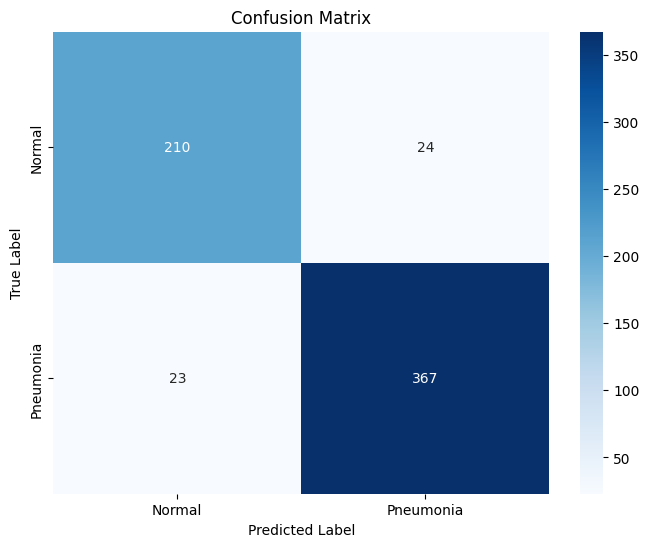

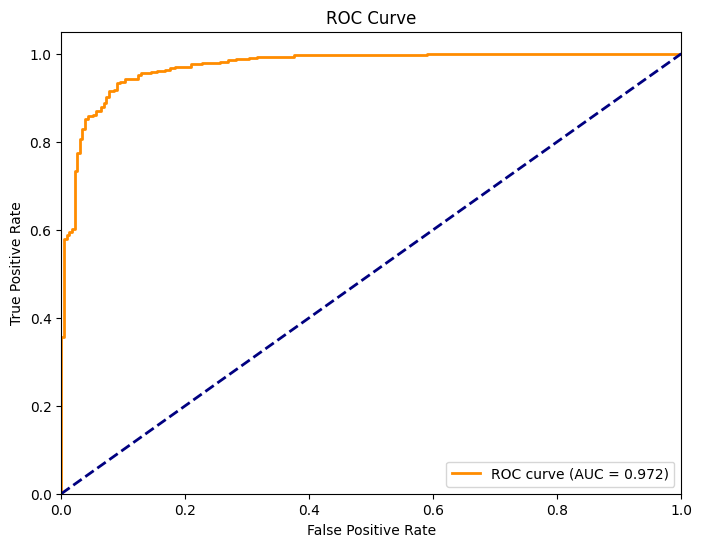


MEDICAL PERFORMANCE METRICS
Sensitivity (Recall): 0.941
Specificity: 0.897
Precision (PPV): 0.939
Negative Predictive Value: 0.901
AUC-ROC: 0.972
💾 Step 8: Saving Model...
✅ PIPELINE COMPLETED SUCCESSFULLY!


(<Sequential name=sequential_1, built=True>,
 {'predictions': array([[8.68164934e-04],
         [4.42608143e-04],
         [9.93481663e-05],
         [6.09207666e-04],
         [1.55963469e-04],
         [2.01583811e-04],
         [1.99231945e-04],
         [2.15861102e-04],
         [9.80020501e-04],
         [2.50089681e-04],
         [5.13231898e-05],
         [4.89588128e-03],
         [1.89475366e-04],
         [1.09701417e-04],
         [2.10034964e-03],
         [5.51265141e-04],
         [9.90415335e-01],
         [5.09103156e-05],
         [7.79272668e-05],
         [3.36723315e-05],
         [7.89857761e-04],
         [1.46210703e-04],
         [7.66515208e-04],
         [2.63757072e-04],
         [2.53439648e-04],
         [5.04610012e-04],
         [2.09147751e-04],
         [3.33487369e-05],
         [6.66140486e-03],
         [2.49092380e-04],
         [9.96543560e-04],
         [2.89950149e-05],
         [3.49900365e-05],
         [1.10368950e-04],
         [2.21905022e-

In [37]:
main()

In [38]:
diagnosis, confidence = predict_pneumonia('pneumonia_densenet121_final.h5', 
                                             'dataset/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Diagnosis: NORMAL
Confidence: 98.1%


In [39]:
diagnosis, confidence = predict_pneumonia('pneumonia_densenet121_final.h5', 
                                             'dataset/chest_xray/test/PNEUMONIA/person3_virus_15.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Diagnosis: PNEUMONIA DETECTED
Confidence: 97.9%


In [40]:
diagnosis, confidence = predict_pneumonia('pneumonia_custom_cnn_final.h5', 
                                             'dataset/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Diagnosis: NORMAL
Confidence: 99.9%


In [41]:
diagnosis, confidence = predict_pneumonia('pneumonia_custom_cnn_final.h5', 
                                             'dataset/chest_xray/test/NORMAL/IM-0033-0001-0001.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Diagnosis: NORMAL
Confidence: 100.0%


In [42]:
diagnosis, confidence = predict_pneumonia('pneumonia_custom_cnn_final.h5', 
                                             'dataset/chest_xray/test/PNEUMONIA/person3_virus_15.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
Diagnosis: PNEUMONIA DETECTED
Confidence: 71.3%
